In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import tensorflow as tf
from neural_network import *
from figure_grid import *

# 2D Illustrative Examples

In this notebook, we'll replicate our results on the three 2D examples we discussed at the beginning of the paper. Although these examples are simple, we think they are an important "unit test" for diverse ensemble training methods; arguably any method that tries to train an ensemble of models that make the same predictions for qualitatively different reasons should recover the ground truth functions on these datasets.

## Define our ground-truth functions and our training sets

In [2]:
# Define a rotation matrix
O = np.pi / 3
R = np.array([[np.cos(O), -np.sin(O)],
              [np.sin(O), np.cos(O)]]).T

# Define our three pairs of functions -- one which will correspond to feature selection,
# another which will correspond to rotated feature selection, and a final one which
# is a nonlinear but angle-preserving transformation of feature selection.
fns = [
  lambda x: x[0],        lambda x: x[1],
  lambda x: R.dot(x)[0], lambda x: R.dot(x)[1],
  lambda x: 2*x[0]*x[1], lambda x: x[0]**2 - x[1]**2
]

# Define their gradients for visualization
grads = [
  lambda x: np.array([1,0]),             lambda x: np.array([0,1]),
  lambda x: R[0],                        lambda x: R[1],
  lambda x: np.array([2*x[1],  2*x[0]]), lambda x: np.array([2*x[0], -2*x[1]])
]

# Give them friendly names
fn_names = [
  '$x$', '$y$',
  '$\\frac{1}{2}x+\\frac{\\sqrt{3}}{2}y$', '$-\\frac{\\sqrt{3}}{2}x+\\frac{1}{2}y$',
  '$2xy$', '$x^2-y^2$'
]

# We're going to evaluate them over R^2 from -10 to 10 -- create a uniform grid
# over this region.
X = np.array([
  [x,y] for x in np.linspace(-10,10,50)
        for y in np.linspace(-10,10,50)])

# Compute their values over the region
f1a,  f1b,  f2a,  f2b,  f3a,  f3b  = (np.array([f(x) for x in X]) for f in fns)
df1a, df1b, df2a, df2b, df3a, df3b = (np.array([g(x) for x in X]) for g in grads)

# We'll define classification labels by the signs of these functions
def labels_for(f):
  return (f > 0).astype(int)

# And we'll construct training sets by training over the half of R^2 where they agree --
# a deliberately ambiguous training procedure.
def agreement_regime(fa, fb):
  ya = labels_for(fa)
  yb = labels_for(fb)
  idx = np.argwhere(ya == yb)[:,0]
  np.random.shuffle(idx)
  return X[idx], ya[idx]
X1, y1 = agreement_regime(f1a, f1b)
X2, y2 = agreement_regime(f2a, f2b)
X3, y3 = agreement_regime(f3a, f3b)

## Define plotting helpers

In [11]:
# Plot contours of a function
def contour(f, cmap='bwr', lines=None, **kw):
  set_lims()
  grid = np.linspace(-10, 10, 150)
  xg, yg = np.meshgrid(grid, grid)
  zg = griddata(X[:,0], X[:,1], f, grid, grid, interp='linear')
  if lines is not None:
    plt.contour(xg, yg, zg, lines, cmap=cmap, **kw)
  else:
    vlim = np.abs(f).max() * 0.95
    plt.contourf(xg, yg, zg, 300, cmap=cmap, vmin=-vlim, vmax=vlim, **kw)
  
# Plot gradients as arrows
def quiver(X, grads, per=15, shuffle=True, **kw):
  set_lims()
  idx = np.arange(len(X))
  if shuffle: np.random.shuffle(idx)
  plt.quiver(X[idx,0][::per], X[idx,1][::per], grads[idx,0][::per], grads[idx,1][::per], **kw)

# Compare two sets of gradients
def dblquiver(g1, g2, X=X, c1='green', c2='purple', shuffle=True, **kw):
  set_lims()
  idx = np.arange(len(X))
  if shuffle: np.random.shuffle(idx)
  quiver(X[idx], g1[idx], shuffle=False, color=c1, **kw)
  quiver(X[idx], g2[idx], shuffle=False, color=c2, **kw)

# Plot three models' accuracies as a 3x3 image
def plot_accs(accs):
  clear_ticks()
  plt.imshow(accs.T, interpolation='none', cmap='RdYlGn')
  for i in range(3):
    for j in range(3):
      plt.text(i,j,'{:.2f}'.format(accs[i][j]), ha='center', va='center', fontsize=12, fontweight=800,
              color=('white' if accs[i][j] < 0.6 or accs[i][j] > 0.9 else 'black'))
  plt.xticks([0,1,2], [])
  plt.yticks([0,1,2], ['Normal','Diverse 1','Diverse 2'], fontsize=12)
  plt.gca().yaxis.tick_right()
      
# Scatterplot a training set
def scat(x,y,per=2, **kw):
  set_lims()
  y1 = np.argwhere(y > 0)[:,0]; np.random.shuffle(y1)
  y2 = np.argwhere(y <= 0)[:, 0]; np.random.shuffle(y2)
  plt.scatter(*x[y1][::per].T, marker='+', color='red', s=50, **kw)
  plt.scatter(*x[y2][::per].T, marker='_', color='blue', s=50, **kw)
  
def plot_info(mi, vmax=2.0): # 2 bits
  plt.imshow(mi, interpolation='none', vmin=0, vmax=vmax)
  clear_ticks()
  
def ylabel(text):
  plt.ylabel(text, fontsize=16, rotation=0, ha='right')
  
def title(txt):
  plt.title(txt, fontsize=16)
  
def funclabel(fn):
  plt.text(0,0,fn,fontsize=16,ha='center',va='center',bbox={'facecolor':'white', 'alpha':0.5})
  
def clear_ticks():
  plt.xticks([])
  plt.yticks([])
  
def set_lims():
  clear_ticks()
  plt.xlim(-10, 10)
  plt.ylim(-10, 10)

## Visualize ground-truth function pairs and corresponding training sets

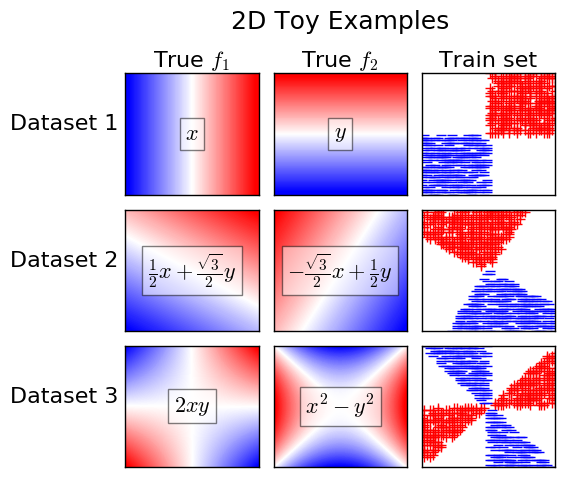

In [12]:
with figure_grid(3,3,rowheight=1.5,rowwidth=5.75) as g:
  g.title('2D Toy Examples', fontsize=18, y=1.05, x=0.6)
  g.next(); contour(f1a); title('True $f_1$'); funclabel(fn_names[0]); plt.ylabel('Dataset 1', fontsize=16, rotation=0, ha='right')
  g.next(); contour(f1b); title('True $f_2$'); funclabel(fn_names[1])
  g.next(); scat(X1, y1); title('Train set')
  g.next(); contour(f2a); funclabel(fn_names[2]); plt.ylabel('Dataset 2', fontsize=16, rotation=0, ha='right')
  g.next(); contour(f2b); funclabel(fn_names[3])
  g.next(); scat(X2, y2)
  g.next(); contour(f3a); funclabel(fn_names[4]); plt.ylabel('Dataset 3', fontsize=16, rotation=0, ha='right')
  g.next(); contour(f3b); funclabel(fn_names[5])
  g.next(); scat(X3, y3)

This visualizes each pair of functions as contour plots, with white areas indicating where the function returns 0. On the right, we show the training set consisting only of points where the pair of functions returns the same label.

## Visualize gradients of ground-truth functions

We can confirm that these functions have orthogonal gradients:

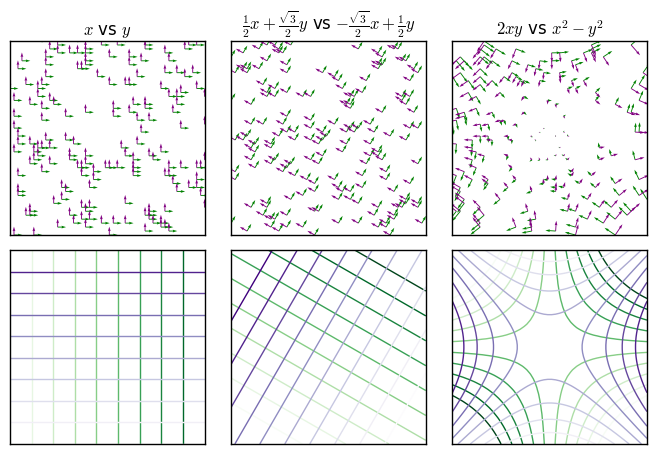

In [5]:
l = np.linspace(-10,10,10)
l2 = np.linspace(-10,10,10)*10
with figure_grid(2,3,rowwidth=6.67,rowheight=2.33) as g:
  g.next(); dblquiver(df1a, df1b); plt.title(fn_names[0] + ' vs ' + fn_names[1])
  g.next(); dblquiver(df2a, df2b); plt.title(fn_names[2] + ' vs ' + fn_names[3], y=1.02)
  g.next(); dblquiver(df3a, df3b); plt.title(fn_names[4] + ' vs ' + fn_names[5])
  g.next(); contour(f1a, lines=l, cmap='Greens'); contour(f1b, lines=l, cmap='Purples')
  g.next(); contour(f2a, lines=l, cmap='Greens'); contour(f2b, lines=l, cmap='Purples')
  g.next(); contour(f3a, lines=l2, cmap='Greens'); contour(f3b, lines=l2, cmap='Purples')

Note that in the final example, the gradients of both functions go to 0 at the origin, which explains why the decision boundaries of the two functions aren't orthogonal there (even if every other contour line is).

## Define network and training helpers

In [6]:
# We'll use a simple 2x256x256x2 fully connected network
class Net(NeuralNetwork):
  @property
  def x_shape(self): return [None, 2]
  @property
  def y_shape(self): return [None, 2]
  def rebuild_model(self, X, **_):
    # We use softplus here because ReLU networks appear to be unable to get high train accuracy
    # on the 2xy vs. x^2-y^2 dataset, even trained normally (not in an ensemble)
    L0 = X
    L1 = tf.layers.dense(L0, 256, name=self.name+'/L1', activation=tf.nn.softplus)
    L2 = tf.layers.dense(L1, 256, name=self.name+'/L2', activation=tf.nn.softplus)
    L3 = tf.layers.dense(L2,   2, name=self.name+'/L3', activation=None)
    return [L1, L2, L3]
  
def train_ensemble(X_train, y_train, fa, fb, **kw):
  tf.reset_default_graph()
  
  # Fit normal net normally
  m0 = Net()
  m0.fit(X_train, y_train, **kw)
  
  # Train ensemble with orthogonal gradient penalty
  m1, m2 = Net.train_diverse_models(2, X_train, y_train, **kw)
  
  # Score all three models on training (f1&f2 over agreement region), f1 (over whole space), and f2 (whole space)
  with tf.Session() as sess:
    m0.init(sess)
    m0t = m0.score_(sess, X_train, y_train)
    m0a = m0.score_(sess, X, labels_for(fa))
    m0b = m0.score_(sess, X, labels_for(fb))
    l0 = m0.batch_eval(sess, m0.binary_logits, X)
  with tf.Session() as sess:
    m1.init(sess)
    m1t = m1.score_(sess, X_train, y_train)
    m1a = m1.score_(sess, X, labels_for(fa))
    m1b = m1.score_(sess, X, labels_for(fb))
    l1 = m1.batch_eval(sess, m1.binary_logits, X)
  with tf.Session() as sess:
    m2.init(sess)
    m2t = m2.score_(sess, X_train, y_train)
    m2a = m2.score_(sess, X, labels_for(fa))
    m2b = m2.score_(sess, X, labels_for(fb))
    l2 = m2.batch_eval(sess, m2.binary_logits, X)
    
  # Possibly reorder models (for more consistent plotting)
  if m1a > m1b:
    return l0, l1, l2, np.array([[m0t, m1t, m2t], [m0a, m1a, m2a], [m0b, m1b, m2b]])
  else:
    return l0, l2, l1, np.array([[m0t, m2t, m1t], [m0a, m2a, m1a], [m0b, m2b, m1b]])

## Run training process 5 times

Just to check the stability of the procedure...

In [7]:
restarts = 5
m1_results = []
m2_results = []
m3_results = []
for i in range(restarts):
  m1_results.append(train_ensemble(X1, y1, f1a, f1b))
  m2_results.append(train_ensemble(X2, y2, f2a, f2b))
  m3_results.append(train_ensemble(X3, y3, f3a, f3b))


Restart 1



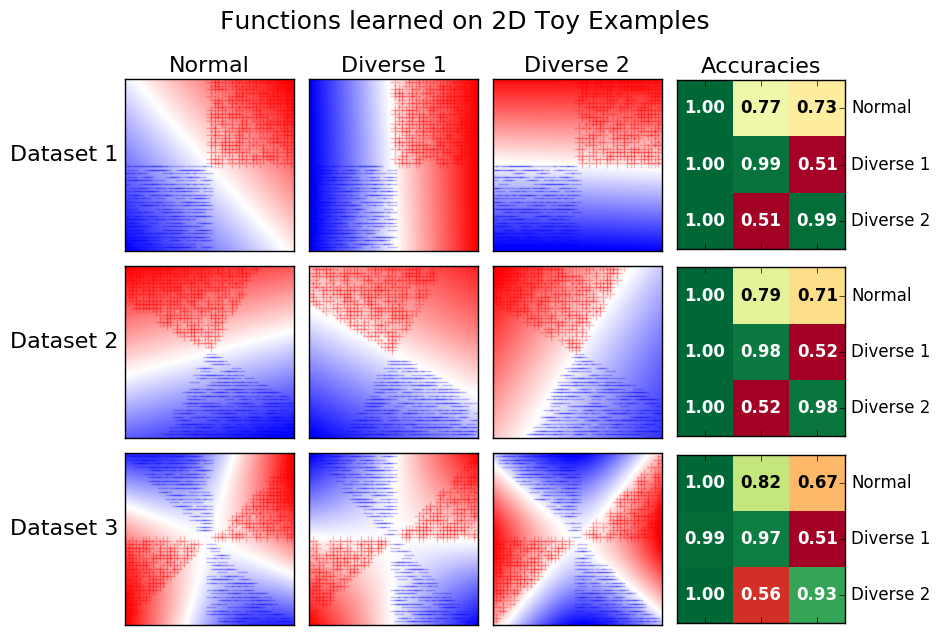


Restart 2



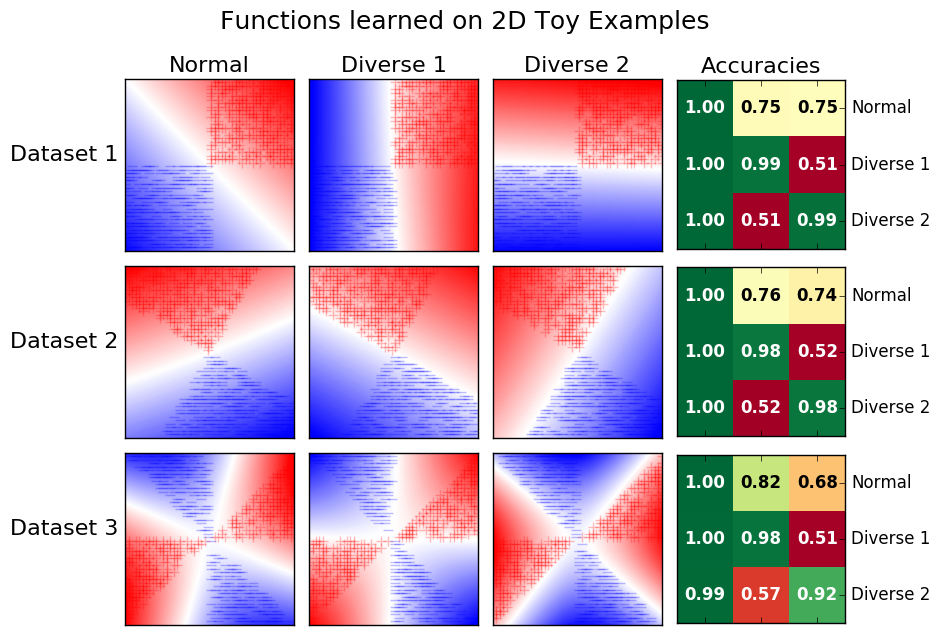


Restart 3



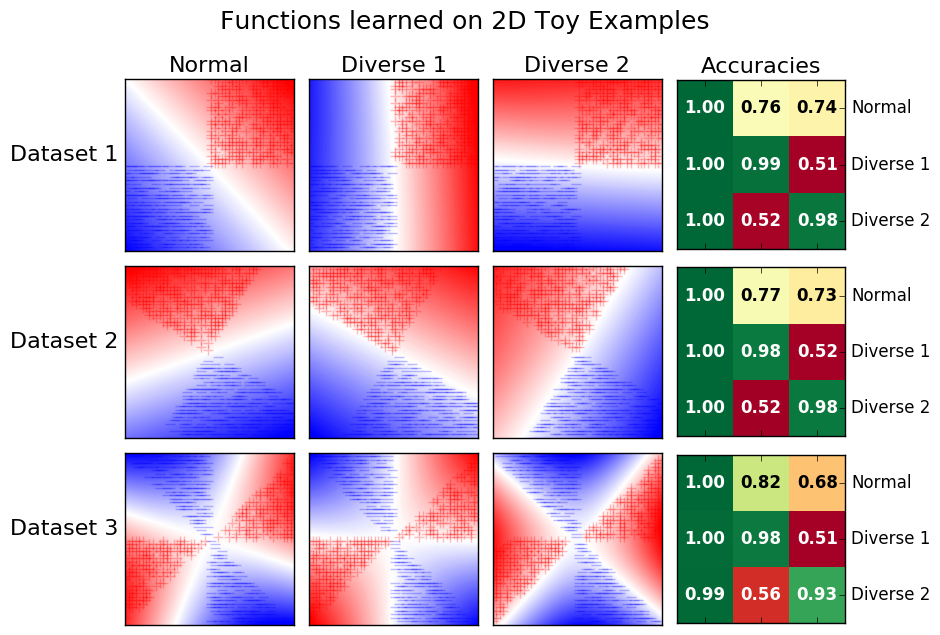


Restart 4



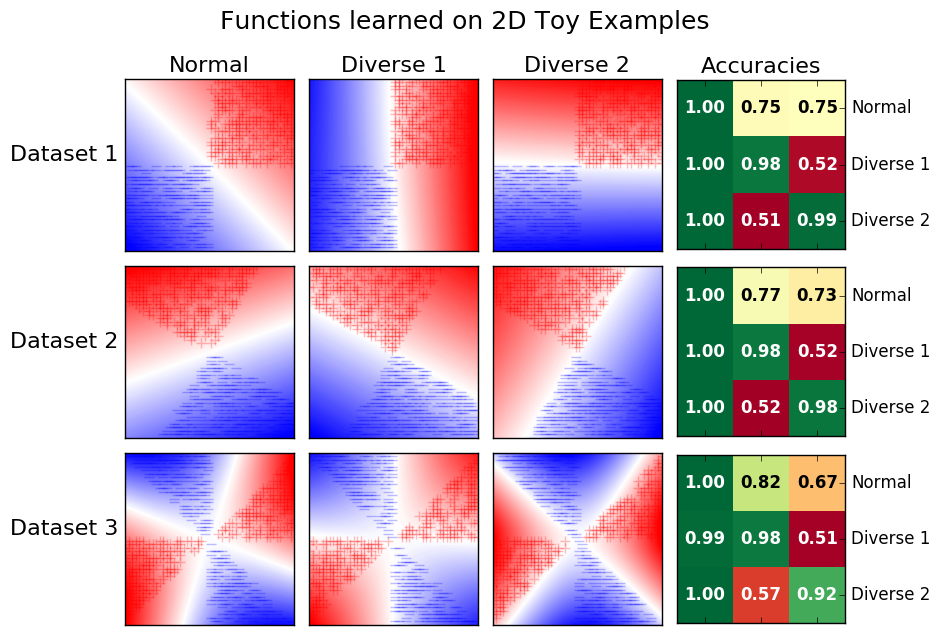


Restart 5



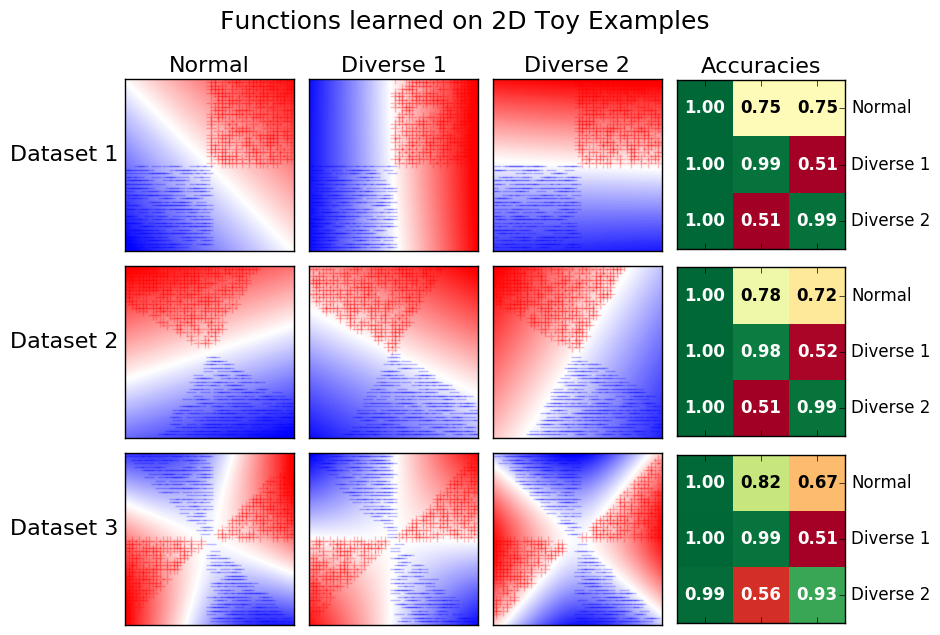

In [13]:
for i in range(5):
  print('\nRestart {}\n'.format(i+1))
  with figure_grid(3,4,rowheight=2, rowwidth=9.4) as g:
    g.fig.suptitle('Functions learned on 2D Toy Examples', fontsize=18, y=1.05)
    g.next(); contour(m1_results[i][0]); scat(X1,y1,alpha=0.25); title('Normal'); ylabel('Dataset 1')
    g.next(); contour(m1_results[i][1]); scat(X1,y1,alpha=0.25); title('Diverse 1')
    g.next(); contour(m1_results[i][2]); scat(X1,y1,alpha=0.25); title('Diverse 2')
    g.next(); plot_accs(m1_results[i][3]); title('Accuracies')

    g.next(); contour(m2_results[i][0]); scat(X2, y2, alpha=0.25); ylabel('Dataset 2')
    g.next(); contour(m2_results[i][1]); scat(X2, y2, alpha=0.25)
    g.next(); contour(m2_results[i][2]); scat(X2, y2, alpha=0.25)
    g.next(); plot_accs(m2_results[i][3])

    g.next(); contour(m3_results[i][0]); scat(X3, y3, alpha=0.25); ylabel('Dataset 3')
    g.next(); contour(m3_results[i][1]); scat(X3, y3, alpha=0.25)
    g.next(); contour(m3_results[i][2]); scat(X3, y3, alpha=0.25)
    g.next(); plot_accs(m3_results[i][3])

On all datasets, and pretty consistently across restarts, we end up learning close approximations of our ground-truth functions (up to the label)!